# Finding the Shortest Path Between Two Points in the State of North Carolina Using `ShortestPath` Action in the `OPTNETWORK` Actionset 

------------------------------------------------------------------------------------------------------------------------------

This Jupyter notebook provides an example of finding the shortest path between the most eastern and western points in North Carolina, considering the road networks. The road network of NC is obtained from [9th DIMACS Implementation Challenge ](http://users.diag.uniroma1.it/challenge9/data/tiger/). We provide the Python Script to download the file and unzip it through the code. However, it is also possible to download the file from the website, unzip it and place it in the working directory so that this program can access it. In that case, you can skip cells 2 and 3.

To read more about the `shortestPath` action, refer to [SAS Documentation](https://go.documentation.sas.com/doc/da/pgmsascdc/default/casactnopt/cas-optnetwork-shortestpath.htm) .

------------------------------------------------------------------------------------------------------------------------------

The flow of this notebook is as follows:

* [Downloading and unzipping the NC Road Network from DIMACS Datasets](#1st-bullet)
* [Reading the data](#2nd-bullet)
* [Slicing the data to get the nodes dataframe](#3rd-bullet)
* [Slicing the data to get the links dataframe](#4th-bullet)
* [Visualizing the road network](#5th-bullet)
* [Connecting to CAS server and uploading the nodes and links dataframes](#6th-bullet)
* [Uploading links and nodes DataFrame to CAS](#7th-bullet)
* [Using `summary` action to calculate the summary statistics of the road network](#8th-bullet)
* [Filtering the road network by finding the largest connected component](#9th-bullet)
* [Visualizing the filtered road network](#10th-bullet)
* [Uploading filtered links and nodes DataFrame to CAS](#11th-bullet)
* [Determining the start and finish nodes](#12th-bullet)
* [Finding the Shortest Path between start and finish nodes](#13th-bullet)
* [Fetching the shortest path from CAS](#14th-bullet)
* [Merging the links in the shortest path with the road network](#15th-bullet)
* [Visualizing the road network and the shortest path between start and finish nodes](#16th-bullet)

------------------------------------------------------------------------------------------------------------------------------
**Prepared by:** Hossein Tohidi (<i class="fa fa-github" aria-hidden="true"></i> [Hossein-Tohidi](https://github.com/Hossein-Tohidi))


In [1]:
import swat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook  
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()),r"../../common/python"))
import requests
import cas_connection as cas 
import zipfile
import gzip
import shutil
import networkx as nx

### Downloading and unzipping the NC Road Network from DIMACS Datasets <a class="anchor" id="1st-bullet"></a>

If you manually downloaded and unzipped the file, you can skip the next two code blocks!

In [2]:
url = "http://users.diag.uniroma1.it/challenge9/data/tiger/NC.tmp.gz"
r = requests.get(url, stream=True)
with open("NC.tmp.gz", 'wb') as fd:
    for chunk in r.iter_content():
        fd.write(chunk)

In [3]:
with gzip.open("NC.tmp.gz", 'rb') as f_in:
    with open('NC.tmp', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

### Reading the data <a class="anchor" id="2nd-bullet"></a>

The data starts with the number of road intersections (nNodes) followed by nNodes rows providing the longitude and latitude of each node. After the nodes' information, the text file provides the number of links (nLinks) followed by 2 * nLinks row of data. Every two rows contain "from" and "to" nodes on one line and "travel time", "spatial distance", and "capacity" on the following line.

In [4]:
df = pd.read_csv('NC.tmp', header=None)
df.head()

,0
0,887630
1,0 -79429920 36123127
2,1 -79429710 36125767
3,2 -79400020 36057382
4,3 -79401165 36057431


### Slicing the data to get the nodes dataframe <a class="anchor" id="3rd-bullet"></a>

In [5]:
nNodes = int(df.iloc[0])
nodesDF = df.iloc[1:nNodes+1,0].str.split('\s+', expand=True).reset_index(drop=True)
nodesDF.columns = ['node', 'lng', 'lat']
nodesDF[['lng','lat']] = nodesDF[['lng','lat']].astype(int)
nodesDF['node']= nodesDF['node'].astype(str)
nodesDF.head()

,node,lng,lat
0,0,-79429920,36123127
1,1,-79429710,36125767
2,2,-79400020,36057382
3,3,-79401165,36057431
4,4,-79284204,36130911


### Slicing the data to get the links dataframe <a class="anchor" id="4th-bullet"></a>

In [6]:
nLinks = int(df.loc[nNodes+1])
linksDF = df.iloc[nNodes+2:,0].str.split('\s', expand=True).reset_index(drop=True)
linksDF = linksDF.iloc[0:2*(nLinks):2,0:2].reset_index(drop = True).merge(
                linksDF.iloc[1:2*(nLinks+1):2,:].reset_index(drop = True), 
                left_index = True, right_index = True)
linksDF.columns = ['from','to','travel time','distance','road category']
linksDF.drop_duplicates(inplace=True)
linksDF[['distance','travel time']] = linksDF[['distance','travel time']].astype(float).round(decimals=2)
linksDF[['from','to']] = linksDF[['from','to']].astype(str)
linksDF.head()

,from,to,travel time,distance,road category
0,0,1,734.94,293.98,41
1,2,3,257.52,103.01,41
2,4,5,546.22,218.49,41
3,6,7,530.34,212.14,41
4,8,9,1084.40,433.76,41


### Visualizing the road network <a class="anchor" id="5th-bullet"></a>

In [7]:
def visualize(nodesDF,linksDF):
    nodesDF['pos'] = list(zip(nodesDF['lng'], nodesDF['lat']))
    linksDF['color'] = linksDF['road category'].astype(int)
    fig, ax = plt.subplots(figsize=(8,6)) 
    G = nx.from_pandas_edgelist(linksDF, source='from', target='to', edge_attr=['color','road category'],create_using=nx.Graph())
    attrs = nodesDF.set_index('node').to_dict('index')
    nx.set_node_attributes(G, attrs)
    pos = nx.get_node_attributes(G, 'pos')
    colors = [G[u][v]['color'] for u,v in G.edges()]
    width = [0.3 if G[u][v]['road category']!='1' else 1 for u,v in G.edges()]
    nx.draw(G, pos, edge_color=colors, width=width, node_size=0, ax=ax)
    plt.show()

<IPython.core.display.Javascript object>


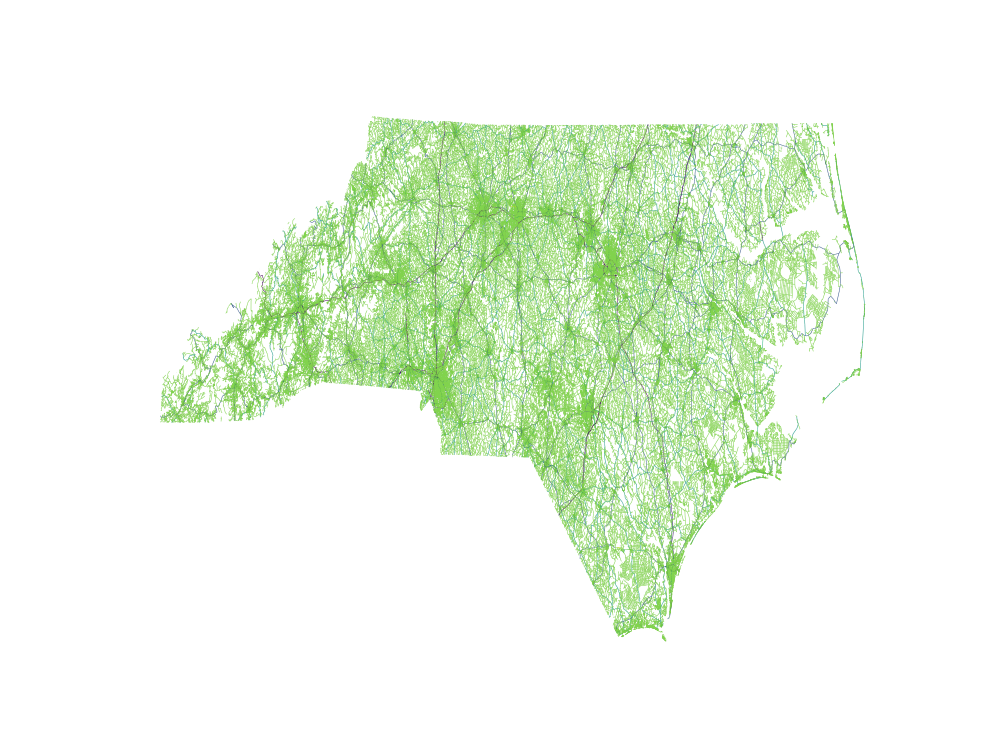

In [8]:
visualize(nodesDF, linksDF)    

### Connecting to CAS server <a class="anchor" id="6th-bullet"></a>

In [9]:
s = cas.reconnect(env_path="../../common/conf/environment.txt")
s.loadActionSet('network')
s.loadActionSet('optNetwork')

NOTE: Added action set 'network'.
NOTE: Added action set 'optNetwork'.


[actionset]

 'optNetwork'

+ Elapsed: 0.00385s, sys: 0.002s, mem: 0.221mb

### Uploading links and nodes DataFrame to CAS <a class="anchor" id="7th-bullet"></a>

In [10]:
swat.options.cas.print_messages=False 
s.upload(linksDF, casout = {'name':'cas_links', 'replace':True})
s.upload(nodesDF, casout = {'name':'cas_nodes', 'replace':True})
swat.options.cas.print_messages=True 

### Using `summary` action to calculate the summary statistics of the road network <a class="anchor" id="8th-bullet"></a>

In [11]:
result = s.network.summary(
                direction   = "undirected",
                indexOffset = 1,
                nodes       = {"name": "cas_nodes"},
                links       = {"name": "cas_links"},
                out         = {"name": "Summary", "replace":True},
                connectedComponents = True
                )
df = s.CASTable('Summary').to_frame()
df

NOTE: The number of nodes in the input graph is 887630.
NOTE: The number of links in the input graph is 1005560.
NOTE: Processing summary metrics.
NOTE: Processing summary metrics used 0.11 (cpu: 0.25) seconds.


,nodes,links,avg_links_per_node,density,self_links_ignored,dup_links_ignored,leaf_nodes,singleton_nodes,concomp,isolated_pairs,isolated_stars
0,887630.0,1005560.0,1.132859,0.000003,0.0,0.0,239142.0,13.0,3074.0,2140.0,531.0


### Filtering the road network by finding the largest connected component<a class="anchor" id="9th-bullet"></a>

As shown in the Summary statistics, the given network is not fully connected. Therefore, the first step is to run the `connectedComponent` action and filter out the linksDF and nodesDF based on the largest component.

In [12]:
result = s.network.connectedComponents(
                indexOffset = 1,
                links       = {"name": 'cas_links'},
                linksvar    = {"vars":['distance','road category']},
                nodes       = {"name": 'cas_nodes'},
                nodesvar    = {"vars":['lng','lat']},
                direction   = "undirected", 
                outNodes    = {"name": "NodeSetOut", "replace":True},
                outLinks    = {"name": "LinkSetOut", "replace":True},
                out         = {"name": "out", "replace":True}
                )
concomp_outNodes = s.CASTable("NodeSetOut").to_frame()
concomp_outLinks = s.CASTable("LinkSetOut").to_frame()
concomp_out = s.CASTable("out").to_frame()
concomp_out.head()

NOTE: The number of nodes in the input graph is 887630.
NOTE: The number of links in the input graph is 1005560.
NOTE: Processing connected components using 32 threads across 1 machines.
NOTE: The graph has 3074 connected components.
NOTE: Processing connected components used 0.14 (cpu: 0.42) seconds.


,concomp,nodes
0,1.0,876954.0
1,1922.0,2.0
2,1937.0,2.0
3,1941.0,8.0
4,1952.0,2.0


In [13]:
largest_concomp = concomp_out.loc[concomp_out['nodes'].argmax(),'concomp']
print(f"The largest connected component: \n concomp ID: {largest_concomp} \n number of nodes: {concomp_out['nodes'].max()}")
filteredLinks = concomp_outLinks.loc[concomp_outLinks['concomp']==largest_concomp].reset_index(drop=True)
filteredLinks.drop('concomp',axis=1,inplace=True)
filteredLinks.head()

The largest connected component: 
 concomp ID: 1.0 
 number of nodes: 876954.0


,from,to,distance,road category
0,141110,141111,855.59,41
1,141110,141112,63.05,41
2,141113,141114,903.54,41
3,141113,141108,596.26,41
4,141115,141116,1824.77,41


In [14]:
filteredNodes = concomp_outNodes.loc[concomp_outNodes['concomp']==largest_concomp].reset_index(drop=True)
filteredNodes.drop('concomp',axis=1,inplace=True)
filteredNodes.head()

,node,lng,lat
0,610930,-79075712.0,35915630.0
1,610945,-79168481.0,35963105.0
2,611003,-78975099.0,36179552.0
3,611029,-79032337.0,36141552.0
4,611072,-78995151.0,36115263.0


### Visualizing the filtered road network <a class="anchor" id="10th-bullet"></a>

<IPython.core.display.Javascript object>


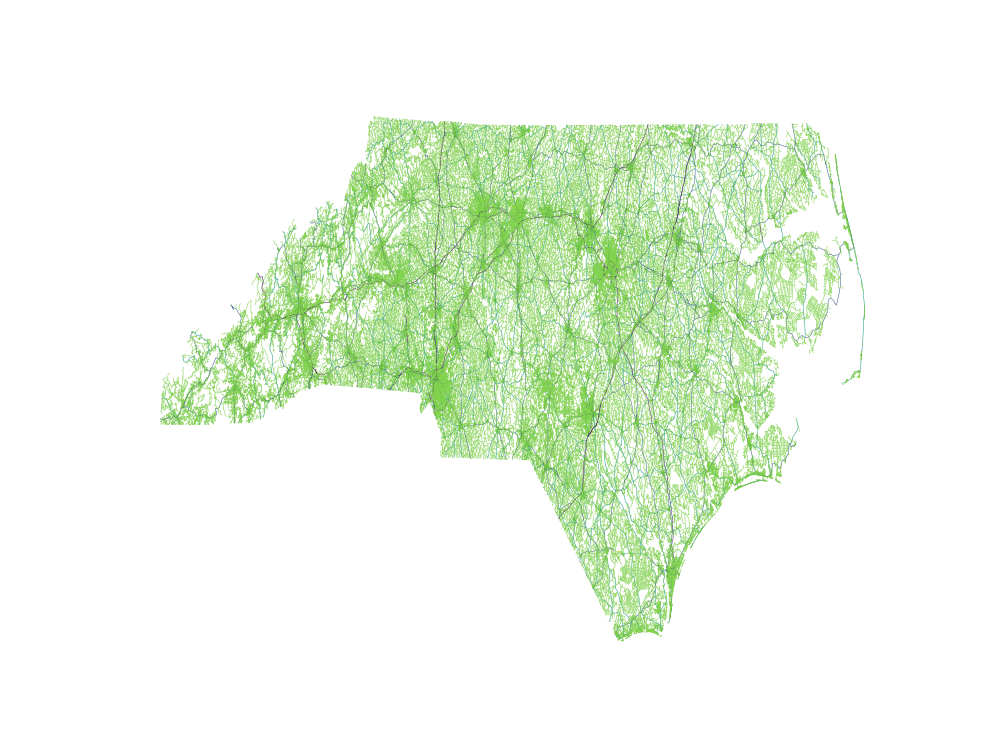

In [15]:
visualize(filteredNodes, filteredLinks)    

### Uploading filtered links and nodes DataFrame to CAS <a class="anchor" id="11th-bullet"></a>

In [16]:
swat.options.cas.print_messages=False 
s.upload(filteredLinks, casout = {'name':'cas_links', 'replace':True})
s.upload(filteredNodes, casout = {'name':'cas_nodes', 'replace':True})
swat.options.cas.print_messages=True 

### Determining the start and finish nodes <a class="anchor" id="12th-bullet"></a>

We assign the starting and finishing points to the most eastern and western points in North Carolina. 

In [17]:
start  = filteredNodes.loc[filteredNodes['lng'].argmax(),'node']
finish = filteredNodes.loc[filteredNodes['lng'].argmin(),'node']
print(f's= {start}, t= {finish}')
nodesDF.loc[(nodesDF['node']==str(start)) | (nodesDF['node']==str(finish))]

s= 232564, t= 165092


,node,lng,lat,pos
165092,165092,-84319866,35003214,"(-84319866, 35003214)"
232564,232564,-75461766,35584676,"(-75461766, 35584676)"


### Finding the Shortest Path between start and finish nodes <a class="anchor" id="13th-bullet"></a>

In [18]:
result = s.optNetwork.shortestPath(
            links     = {'name':'cas_links'},
            direction = 'undirected',
            source    = start,
            sink      = finish,
            linksvar  = {'weight': 'distance', 'vars':['distance','road category']},
            outPaths  = {'name': 'ShortPathP', 'replace':True})

NOTE: The number of nodes in the input graph is 876954.
NOTE: The number of links in the input graph is 997613.
NOTE: Processing shortest paths problem using 32 threads across 1 machines.
NOTE: Processing the shortest paths problem between 1 source nodes and 1 sink nodes.
NOTE: Processing the shortest paths problem used 1.14 (cpu: 1.00) seconds.


### Fetching the shortest path from CAS <a class="anchor" id="14th-bullet"></a>

In [19]:
df = s.CASTable('ShortPathP').to_frame()
df[['from','to']] = df[['from','to']].astype(str) 
df['in_SP'] = 1
df = df.drop(['source','sink','order'], axis =1)
df.head()

,from,to,distance,road category,in_SP
0,231913,232564,51.29,41,1
1,231913,231914,79.08,41,1
2,231914,231912,47.63,41,1
3,231910,231912,58.51,41,1
4,231910,231911,271.13,41,1


### Merging the links in the shortest path with the road network <a class="anchor" id="15th-bullet"></a>

In [20]:
linksDF_full = filteredLinks.merge(df,how = 'left', on=["from", "to",'distance','road category'])
linksDF_full.loc[linksDF_full['in_SP']==1,'road category'] = '1' #to differentiate the roads included in the shortest path
linksDF_full.head()

,from,to,distance,road category,color,in_SP
0,141110,141111,855.59,41,41,NaN
1,141110,141112,63.05,41,41,NaN
2,141113,141114,903.54,41,41,NaN
3,141113,141108,596.26,41,41,NaN
4,141115,141116,1824.77,41,41,NaN


### Visualizing the road network and the shortest path between start and finish nodes <a class="anchor" id="16th-bullet"></a>

<IPython.core.display.Javascript object>


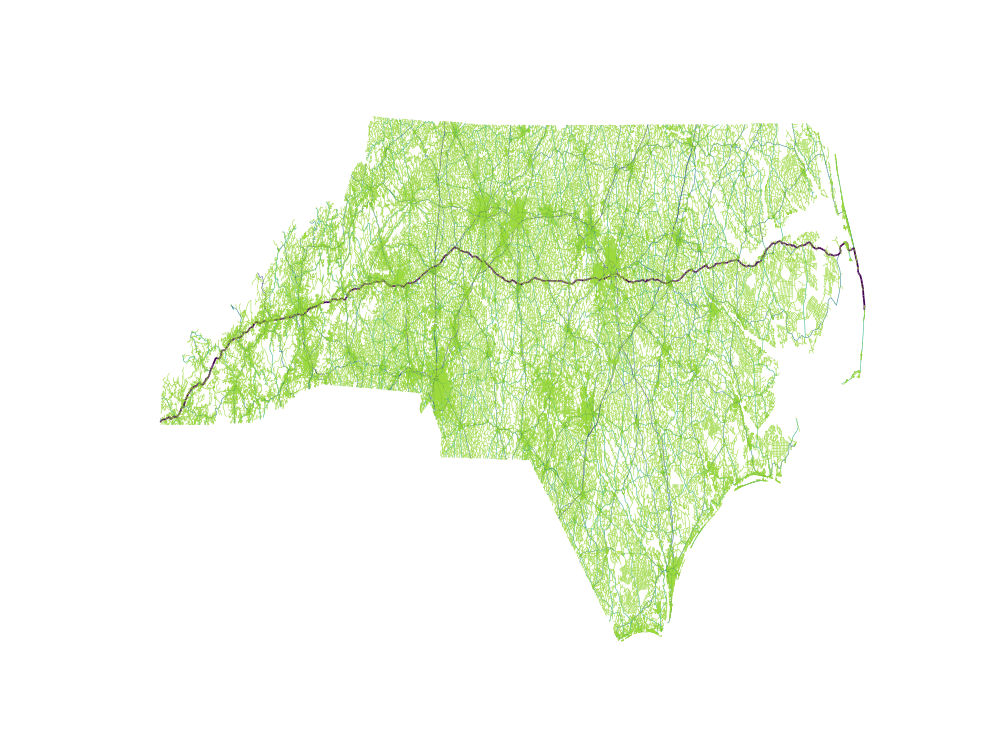

In [21]:
visualize(filteredNodes,linksDF_full)